# Trigger Word Detection (TWD) Part 1

In [1]:
from pydub import AudioSegment as AS
from pydub.playback import play

import librosa, librosa.display
import matplotlib.pyplot as plt

import numpy as np
import random

import glob

E:\SiddC\ML_ANN\Anaconda\Anaconda\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
E:\SiddC\ML_ANN\Anaconda\Anaconda\lib\site-packages\pydub\utils.py:184: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [2]:
file_dict = {}
i = 0

# DIRECTORY : audio --> mutiple folders --> multiple .wav files

for filename in glob.glob('audio\*'):
    file_dict[i] = filename
    i = i + 1

In [3]:
file_dict

{0: 'audio\\bed',
 1: 'audio\\bird',
 2: 'audio\\cat',
 3: 'audio\\dog',
 4: 'audio\\down',
 5: 'audio\\eight',
 6: 'audio\\five',
 7: 'audio\\four',
 8: 'audio\\go',
 9: 'audio\\happy',
 10: 'audio\\house',
 11: 'audio\\left',
 12: 'audio\\marvin',
 13: 'audio\\nine',
 14: 'audio\\no',
 15: 'audio\\off',
 16: 'audio\\on',
 17: 'audio\\one',
 18: 'audio\\right',
 19: 'audio\\seven',
 20: 'audio\\sheila',
 21: 'audio\\six',
 22: 'audio\\stop',
 23: 'audio\\three',
 24: 'audio\\tree',
 25: 'audio\\two',
 26: 'audio\\up',
 27: 'audio\\wow',
 28: 'audio\\yes',
 29: 'audio\\zero',
 30: 'audio\\_background_noise_'}

In [4]:
flag = file_dict[12]
file_dict[12] = file_dict[29]
file_dict[29] = flag

In [5]:
def merge(bg, ls1, ls2):
    
    ls = ls1 + ls2 
    op_len = 1000
    
    # maximum gap = total background / total number of words
    max_gap = int((bg_time/( 2 * pos_neg_count)) * 10)
    ty = np.zeros((op_len,),dtype = int)
    
    # This returns all numbers between 0 and 2*pos_neg_count in a random order
    numbers = random.sample(range(0, 2 * pos_neg_count) , 2 * pos_neg_count)
    
    # loc1 -> Location which determines where the audio should be overlayed
    loc1 = len(bg) * random.randint(0, max_gap) / 100

    for i in range(len(numbers)):
        
        # Overlay a sound on the background
        bg = bg.overlay(ls[numbers[i]], position = loc1)
        
        # If the ovrlayed sound is the trigger word, change the next 50 0s into 1s
        if numbers[i] < pos_neg_count:
            ins_loc = loc1 + len(ls[numbers[i]])
            ty[int(ins_loc * op_len/len(bg)) : int((ins_loc + 500) * op_len/len(bg))] = 1 

        # loc1 is updated     
        loc1 = (len(bg) * random.randint(10, max_gap) / 100) + loc1
        
    return ty, bg

In [8]:
tx_list = []
ty_list = []
    
window = 2048
slide = 256


pos_neg_count = 3 # 6 sounds = 3 positive + 3 negative
bg_time = 10  # Total background duration

for samp in range(5000):
    pos = []
    neg = []
    
    rand = random.randint(10, 15)
    
    # Randomly select a background and choose 10 sec 
    bg = (AS.from_wav(random.choice(glob.glob('audio\_background_noise_\*.wav')))[rand * 1000 : (rand + bg_time) * 1000]) - rand
    
    # Randomly select negative words
    for i in range(pos_neg_count):
        filename = random.choice(glob.glob('audio\marvin\*.wav'))
        pos.append(AS.from_wav(filename))
        
    # Randomly select positive word    
    for j in range(pos_neg_count):
        choice = random.randint(0, 28)
        filename = random.choice(glob.glob(file_dict[choice] + '\*.wav'))
        neg.append(AS.from_wav(filename)) 
        
    ty, wav_file = merge(bg, pos, neg)
    
    ty_list.append(ty)

    targetfile = 'generated\inp' + str(samp) + '.wav'
    
    wav_file.export(targetfile, format="wav")
    signal, sr = librosa.load(targetfile, sr = 16000) # Sample rate = 16kHz

    stft = librosa.core.stft(signal, hop_length = slide, n_fft = window)
    spectrogram = np.abs(stft)

    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    tx_list.append(log_spectrogram)


In [9]:
trainy = np.stack(ty_list)
trainx = np.stack(tx_list)

np.save('generated\ trainx.npy', trainx)
np.save('generated\ trainy.npy', trainy)

print(trainx.shape,trainy.shape)

(5000, 1025, 626) (5000, 1000)


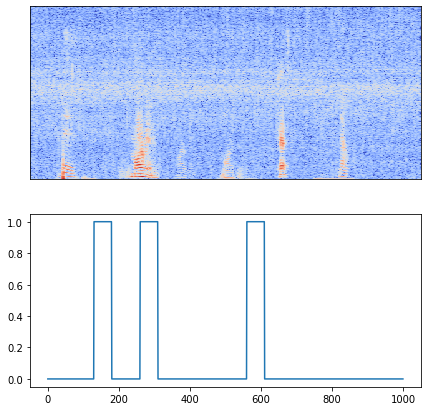

In [11]:
fig=plt.subplots(figsize=(7,7))
plt.subplot(2,1,1)
librosa.display.specshow(trainx[100], sr = sr, hop_length = slide)
plt.subplot(2,1,2)
plt.plot(trainy[0])
plt.show()